In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import os
import torchattacks

print("Libraries imported.")

Libraries imported.


In [2]:
# Cell 2: Define Constants and Paths
# Paths (relative to the 'notebooks' folder)
DATA_DIR = "../data/processed"
MODEL_DIR = "../models"
TEST_FILE = os.path.join(DATA_DIR, "test.pt")
BASELINE_MODEL_PATH = os.path.join(MODEL_DIR, "cnn_classifier.pth")
PURIFIER_MODEL_PATH = os.path.join(MODEL_DIR, "denoising_autoencoder.pth") # Use the best one!
FIGURES_DIR = "../results/figures"
DETECTION_PLOT_PATH = os.path.join(FIGURES_DIR, "detection_feature_distributions.png")

os.makedirs(FIGURES_DIR, exist_ok=True)

# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
BATCH_SIZE = 128

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Cell 3: Define All Helper Models and Functions

# Copied from src/model_zoo.py
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x); x = F.relu(x); x = self.pool(x)
        x = self.conv2(x); x = F.relu(x); x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7); x = self.dropout(x)
        x = self.fc1(x); x = F.relu(x); x = self.fc2(x)
        return x

# Copied from src/model_zoo.py
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.up2 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = F.relu(self.enc1(x)); x = self.pool1(x)
        x = F.relu(self.enc2(x)); x = self.pool2(x)
        x = F.relu(self.up1(x)); x = F.relu(self.dec1(x))
        x = F.relu(self.up2(x)); x = torch.tanh(self.dec2(x))
        return x

# Copied from src/defense.py
def calculate_softmax_entropy(logits):
    probs = F.softmax(logits, dim=1)
    log_probs = torch.log(probs + 1e-9)
    entropy = -torch.sum(probs * log_probs, dim=1)
    return entropy

# Copied from src/defense.py
def get_reconstruction_error(autoencoder, images, criterion):
    reconstructed_images = autoencoder(images)
    errors = criterion(reconstructed_images, images)
    while errors.dim() > 1:
        errors = errors.mean(dim=-1)
    return errors

print("Helper models and functions defined.")

Helper models and functions defined.


In [4]:
# Cell 4: Load Models and Data
try:
    # Load Classifier
    classifier = BaseCNN().to(DEVICE)
    classifier.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=DEVICE))
    classifier.eval()
    print(f"Classifier loaded from {BASELINE_MODEL_PATH}")

    # Load Denoising Autoencoder
    autoencoder = Autoencoder().to(DEVICE)
    autoencoder.load_state_dict(torch.load(PURIFIER_MODEL_PATH, map_location=DEVICE))
    autoencoder.eval()
    print(f"Purifier loaded from {PURIFIER_MODEL_PATH}")

    # Load data
    test_images, test_labels = torch.load(TEST_FILE)
    test_ds = TensorDataset(test_images, test_labels)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    print("Test data loaded.")

except FileNotFoundError as e:
    print(f"---!!! ERROR: File not found! !!!---")
    print(e)
    print("Please make sure you have run Notebook 2 and your DAE training script.")

Classifier loaded from ../models\cnn_classifier.pth
Purifier loaded from ../models\denoising_autoencoder.pth
Test data loaded.


In [5]:
# Cell 5: Feature Extraction Function
def get_features(model, ae, data_loader, device, attack=None):
    model.eval(); ae.eval()
    all_recon_errors, all_entropies = [], []
    recon_criterion = nn.MSELoss(reduction='none')
    
    desc = "Extracting Adversarial Features" if attack else "Extracting Clean Features"
    
    for images, labels in tqdm(data_loader, desc=desc):
        images, labels = images.to(device), labels.to(device)
        
        with torch.enable_grad():
            if attack:
                images.requires_grad = True
                input_images = attack(images, labels)
            else:
                input_images = images

        with torch.no_grad():
            input_images = input_images.detach()
            recon_errors = get_reconstruction_error(ae, input_images, recon_criterion)
            all_recon_errors.append(recon_errors.cpu().numpy())
            
            logits = model(input_images)
            entropies = calculate_softmax_entropy(logits)
            all_entropies.append(entropies.cpu().numpy())
            
    return np.concatenate(all_recon_errors), np.concatenate(all_entropies)

In [6]:
# Cell 6: Extract Features for Clean and Adversarial Data
# Initialize FGSM attack
fgsm_attack = torchattacks.FGSM(classifier, eps=0.3)
fgsm_attack.set_normalization_used(mean=MNIST_MEAN, std=MNIST_STD)

# Get features for clean data
clean_errors, clean_entropy = get_features(
    classifier, autoencoder, test_loader, DEVICE, attack=None
)

# Get features for adversarial data
adv_errors, adv_entropy = get_features(
    classifier, autoencoder, test_loader, DEVICE, attack=fgsm_attack
)

print("\nFeature extraction complete.")
print(f"Clean Error (mean):   {clean_errors.mean():.6f} | Adv Error (mean):   {adv_errors.mean():.6f}")
print(f"Clean Entropy (mean): {clean_entropy.mean():.6f} | Adv Entropy (mean): {adv_entropy.mean():.6f}")

Extracting Clean Features:   0%|          | 0/79 [00:00<?, ?it/s]

Extracting Adversarial Features:   0%|          | 0/79 [00:00<?, ?it/s]


Feature extraction complete.
Clean Error (mean):   0.354067 | Adv Error (mean):   0.646296
Clean Entropy (mean): 0.016101 | Adv Entropy (mean): 0.534324


Plotting feature distributions and saving to ../results/figures\detection_feature_distributions.png...


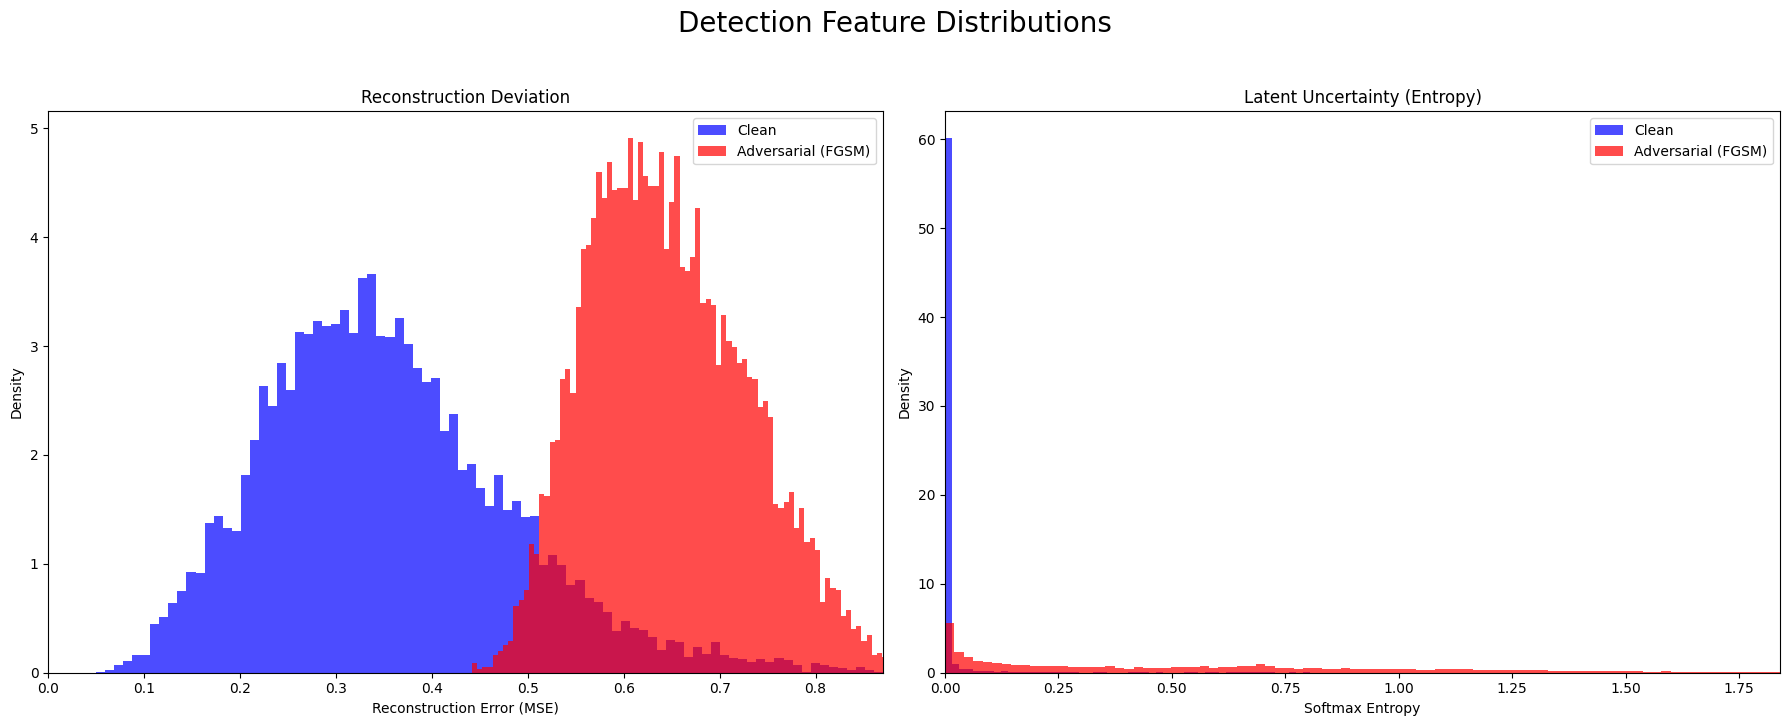

Plot saved.


In [7]:
# Cell 7: Plot Feature Distributions
print(f"Plotting feature distributions and saving to {DETECTION_PLOT_PATH}...")
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Reconstruction Error
ax1.hist(clean_errors, bins=100, alpha=0.7, label="Clean", color="blue", density=True)
ax1.hist(adv_errors, bins=100, alpha=0.7, label="Adversarial (FGSM)", color="red", density=True)
ax1.set_xlabel("Reconstruction Error (MSE)")
ax1.set_ylabel("Density")
ax1.set_title("Reconstruction Deviation")
ax1.legend()
# Set x-limits to focus on the main distributions
ax1.set_xlim(0, max(np.percentile(clean_errors, 99.5), np.percentile(adv_errors, 99.5)))

# Plot 2: Softmax Entropy
ax2.hist(clean_entropy, bins=100, alpha=0.7, label="Clean", color="blue", density=True)
ax2.hist(adv_entropy, bins=100, alpha=0.7, label="Adversarial (FGSM)", color="red", density=True)
ax2.set_xlabel("Softmax Entropy")
ax2.set_ylabel("Density")
ax2.set_title("Latent Uncertainty (Entropy)")
ax2.legend()
ax2.set_xlim(0, max(np.percentile(clean_entropy, 99.5), np.percentile(adv_entropy, 99.5)))


fig.suptitle("Detection Feature Distributions", fontsize=20, y=1.03)
plt.tight_layout()

plt.savefig(DETECTION_PLOT_PATH)
plt.show()

print("Plot saved.")